In [ ]:
# glove embeddings dl
# !wget https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
# !unzip -q glove.6B.zip

In [2]:
import os
import pandas as pd 
from gensim.models import KeyedVectors
import matplotlib.pyplot as plt
import nltk
from nltk import word_tokenize as tokenize
from nltk.corpus import stopwords as stopwords
from nltk.stem import PorterStemmer, SnowballStemmer
import torch
from torch.utils.data import DataLoader, Dataset
import numpy as np
from torch import nn
from tqdm import tqdm
import uuid
import re
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import json

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')



[nltk_data] Downloading package punkt to /Users/rfd/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/rfd/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/rfd/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
try :
  from google.colab import drive
  IN_COLAB = True
except:
  IN_COLAB = False
print('IN COLAB: ', IN_COLAB)


parentdir = "./propaganda_dataset_v2"
train_file= "propaganda_train.tsv"
val_file= "propaganda_val.tsv"

train_path=os.path.join(parentdir,train_file)
val_path=os.path.join(parentdir,val_file)

if IN_COLAB:
  train_path = '/content/propaganda_train.tsv'
  val_path = '/content/propaganda_val.tsv'

train_df=pd.read_csv(train_path,delimiter="\t",quotechar='|')
val_df=pd.read_csv(val_path,delimiter="\t",quotechar='|')


IN COLAB:  False


In [4]:
def transform_binaryify(row):
    new_value = 0 if row['label'] == 'not_propaganda' else 1
    return new_value

def transform_strip_tag(row):
    sent = row['tagged_in_context']
    cleaned_string = sent.replace("<BOS>", "")
    cleaned_string = cleaned_string.replace("<EOS>", "")
    return cleaned_string


train_df['propaganda'] = train_df.apply(transform_binaryify, axis=1)
train_df['original_without_snip_tags'] = train_df.apply(transform_strip_tag, axis=1)


val_df['propaganda'] = val_df.apply(transform_binaryify, axis=1)
val_df['original_without_snip_tags'] = val_df.apply(transform_strip_tag, axis=1)

train_df
val_df

,label,tagged_in_context,propaganda,original_without_snip_tags
0,not_propaganda,"On average, between 300 and 600 infections are...",0,"On average, between 300 and 600 infections are..."
1,causal_oversimplification,Mostly because <BOS> the country would not las...,1,Mostly because the country would not last lon...
2,appeal_to_fear_prejudice,Lyndon Johnson <BOS> gets Earl Warren and Sen....,1,Lyndon Johnson gets Earl Warren and Sen. Rich...
3,not_propaganda,<BOS> You <EOS> may opt out at anytime.,0,You may opt out at anytime.
4,repetition,It must be exacted from him directly in order ...,1,It must be exacted from him directly in order ...
...,...,...,...,...
635,not_propaganda,"NewsCatholic Church, <BOS> Family, Marriage <E...",0,"NewsCatholic Church, Family, Marriage"
636,not_propaganda,"Remember our saying, modern day fairy <BOS> ta...",0,"Remember our saying, modern day fairy tales s..."
637,not_propaganda,Why <BOS> not <EOS> open up to Iran with massi...,0,Why not open up to Iran with massive amounts...
638,flag_waving,<BOS> He also sang an Islamic State fight song...,1,He also sang an Islamic State fight song and ...


In [5]:
def load_glove_embeddings(file_path):
    embeddings = {}
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings

# Load GloVe embeddings
glove_file_path = './glove.6B/glove.6B.300d.txt'
glove_embeddings = load_glove_embeddings(glove_file_path)


In [6]:
def transform_tokens_to_glove_no_stems(string, embeddings, pool_type='mean', normalise=False, len=300):
  vectors = []
  stops = set(stopwords.words('english'))
  original_tokens = tokenize(string)
  cleaned_tokens = [ w for w in original_tokens if w.isalpha() and w not in stops]
  
  for token in cleaned_tokens:
      if token in embeddings:
          vector = embeddings[token]
          if normalise:
              vector = vector / np.linalg.norm(vector)
          vectors.append(vector)
          
  if not vectors:
      return np.zeros(len)
  if pool_type == 'mean':
      return np.mean(vectors, axis=0)
  elif pool_type == 'max':
      return np.max(vectors, axis=0)
  else:
      raise ValueError("Invalid pool_type. Choose either 'mean' or 'max'.")
  

def transform_tokens_to_glove_with_stems(string, embeddings, pool_type='mean', normalise=False):
    stops = set(stopwords.words('english'))
    porter_stemmer = PorterStemmer()
    snowball_stemmer = SnowballStemmer('english')
    vectors = []
    original_tokens = tokenize(string)
    cleaned_tokens = [w for w in original_tokens if len(w) > 1 and w.isalpha() and w not in stops]
    for token in cleaned_tokens:
        if token in embeddings:
            vector = embeddings[token]
            if normalise:
                vector = vector / np.linalg.norm(vector)
            vectors.append(vector)
        else:
            porter_stem = porter_stemmer.stem(token)
            snowball_stem = snowball_stemmer.stem(token)
            if porter_stem in embeddings:
                vector = embeddings[porter_stem]
                if normalise:
                    vector = vector / np.linalg.norm(vector)
                vectors.append(vector)
            elif snowball_stem in embeddings:
                vector = embeddings[snowball_stem]
                if normalise:
                    vector = vector / np.linalg.norm(vector)
                vectors.append(vector)
    if not vectors:
        return np.zeros(300)
    if pool_type == 'mean':
        return np.mean(vectors, axis=0)
    elif pool_type == 'max':
        return np.max(vectors, axis=0)
    else:
        raise ValueError("Invalid pool_type. Choose either 'mean' or 'max'.")

# check functions working as expected
sentence = "This is an example sentence."
embedding = transform_tokens_to_glove_no_stems(sentence, glove_embeddings, pool_type='mean', normalise=False)
embedding = transform_tokens_to_glove_with_stems(sentence, glove_embeddings, pool_type='mean', normalise=False)
print(embedding)

[-3.34453344e-01 -2.35425994e-01 -2.70007998e-01 -2.53540009e-01
 -6.54696524e-02 -1.35613337e-01  9.06866565e-02 -3.52143317e-01
 -4.80129987e-01 -1.05178678e+00  2.03958675e-01 -1.21916495e-01
 -3.39329988e-01 -1.17597662e-01  6.10233359e-02 -1.22426666e-01
  2.01176003e-01  5.26266657e-02 -1.39533892e-01 -4.30886656e-01
  4.72079962e-02 -1.74243331e-01  4.36844975e-02 -2.01134339e-01
 -5.27216680e-02 -4.23466675e-02  2.24244654e-01 -2.24231318e-01
  8.83833040e-03 -4.01423335e-01 -1.85234979e-01  1.86613321e-01
 -7.39266574e-02  5.98043315e-02  1.16076671e-01 -1.99541643e-01
 -2.58783311e-01 -3.85793328e-01 -1.06729992e-01  1.54140994e-01
  5.03346324e-01 -9.55793336e-02 -3.10696661e-01  1.18880995e-01
  1.28136622e-02 -8.34829733e-02 -2.29526553e-02  4.77993339e-01
 -9.13500190e-02  2.91133318e-02 -2.66466677e-01  1.48003325e-01
  3.52866650e-01  1.50899664e-01  1.85936674e-01  6.92460015e-02
  5.67033254e-02 -2.74230003e-01  1.13710016e-02 -9.46133360e-02
  4.25999999e-01  1.41406

In [7]:
class CustomPropagandaDataset_vanilla(Dataset):
    def __init__(self,df, glove_embeddings, pool = 'mean', stems=False):
        self.stems = stems
        self.labels=torch.tensor([label for label in df['propaganda']])
        
        if self.stems==True:
            self.texts=torch.tensor([transform_tokens_to_glove_with_stems(string, glove_embeddings, pool_type=pool, normalise=False) for string in df['original_without_snip_tags']])
        else:    
            self.texts=torch.tensor([transform_tokens_to_glove_no_stems(string, glove_embeddings, pool_type=pool, normalise=False) for string in df['original_without_snip_tags']])
        
    def classes(self):
        return self.labels
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self,idx):
        texts=self.texts[idx]
        y=self.labels[idx]
        return texts,y



In [8]:
class Custom_MLP(nn.Module):
    def __init__(self, dropout=0.5, num_classes=2):
        super().__init__()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.linear_1 = nn.Linear(300, 128)
        self.bn1 = nn.BatchNorm1d(128)  # Add BatchNorm after linear_1
        self.linear_2 = nn.Linear(128, 128)
        self.bn2 = nn.BatchNorm1d(128)  # Add BatchNorm after linear_2
        self.linear_3 = nn.Linear(128, num_classes)

    def forward(self, inputs):
        x = self.linear_1(inputs)
        x = self.bn1(x)  # Apply BatchNorm before activation
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear_2(x)
        x = self.bn2(x)  # Apply BatchNorm before activation
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear_3(x)
        return x

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


/var/folders/bl/31xztvt94dv9bx23976lfvxh0000gn/T/ipykernel_4912/3792475613.py:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  self.texts=torch.tensor([transform_tokens_to_glove_with_stems(string, glove_embeddings, pool_type=pool, normalise=False) for string in df['original_without_snip_tags']])
2024-05-07 22:12:35.063025: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epochs: 1 | Train Loss: 0.008 | Train Accuracy: 0.520
Val loss: 0.008 | Val Accuracy: 0.484
Epochs: 2 | Train Loss: 0.007 | Train Accuracy: 0.550
Val loss: 0.008 | Val Accuracy: 0.544
Epochs: 3 | Train Loss: 0.007 | Train Accuracy: 0.562
Val loss: 0.007 | Val Accuracy: 0.598
Epochs: 4 | Train Loss: 0.007 | Train Accuracy: 0.571
Val loss: 0.007 | Val Accuracy: 0.631
Epochs: 5 | Train Loss: 0.007 | Train Accuracy: 0.579
Val loss: 0.007 | Val Accuracy: 0.641
Epochs: 6 | Train Loss: 0.007 | Train Accuracy: 0.606
Val loss: 0.007 | Val Accuracy: 0.659
Epochs: 7 | Train Loss: 0.007 | Train Accuracy: 0.609
Val loss: 0.007 | Val Accuracy: 0.662
Epochs: 8 | Train Loss: 0.007 | Train Accuracy: 0.622
Val loss: 0.007 | Val Accuracy: 0.661
Epochs: 9 | Train Loss: 0.007 | Train Accuracy: 0.609
Val loss: 0.007 | Val Accuracy: 0.661
Epochs: 10 | Train Loss: 0.007 | Train Accuracy: 0.619
Val loss: 0.007 | Val Accuracy: 0.667
Epochs: 11 | Train Loss: 0.006 | Train Accuracy: 0.653
Val loss: 0.007 | Val Ac

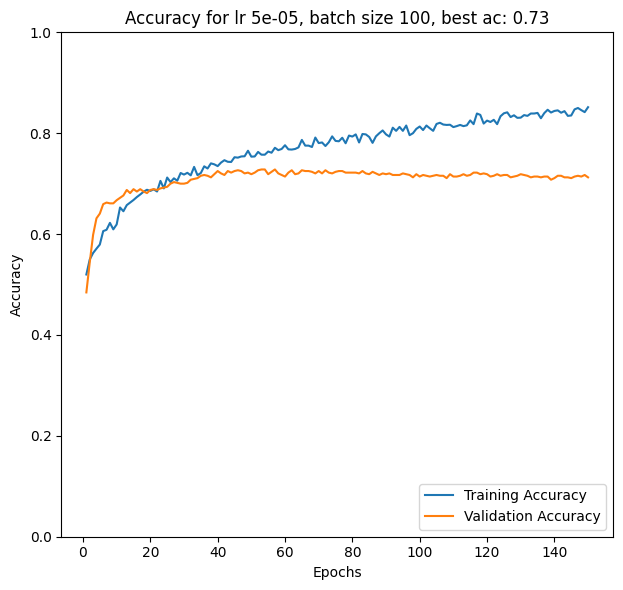

Classification Report:
              precision    recall  f1-score   support

     class 0       0.77      0.68      0.72       331
     class 1       0.69      0.78      0.73       309

    accuracy                           0.73       640
   macro avg       0.73      0.73      0.73       640
weighted avg       0.73      0.73      0.73       640

Epochs: 1 | Train Loss: 0.008 | Train Accuracy: 0.498
Val loss: 0.008 | Val Accuracy: 0.519
Epochs: 2 | Train Loss: 0.008 | Train Accuracy: 0.501
Val loss: 0.007 | Val Accuracy: 0.562
Epochs: 3 | Train Loss: 0.007 | Train Accuracy: 0.532
Val loss: 0.007 | Val Accuracy: 0.608
Epochs: 4 | Train Loss: 0.007 | Train Accuracy: 0.541
Val loss: 0.007 | Val Accuracy: 0.616
Epochs: 5 | Train Loss: 0.007 | Train Accuracy: 0.557
Val loss: 0.007 | Val Accuracy: 0.650
Epochs: 6 | Train Loss: 0.007 | Train Accuracy: 0.581
Val loss: 0.007 | Val Accuracy: 0.655
Epochs: 7 | Train Loss: 0.007 | Train Accuracy: 0.579
Val loss: 0.007 | Val Accuracy: 0.672
Epochs

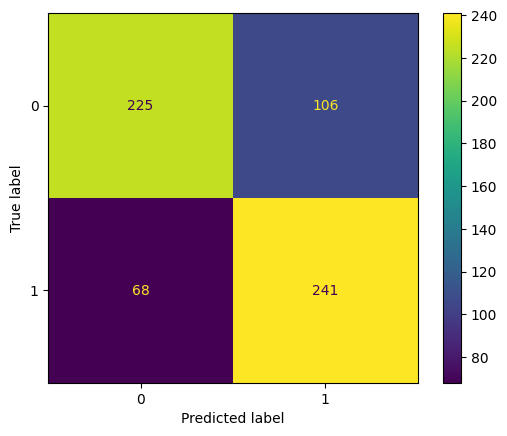

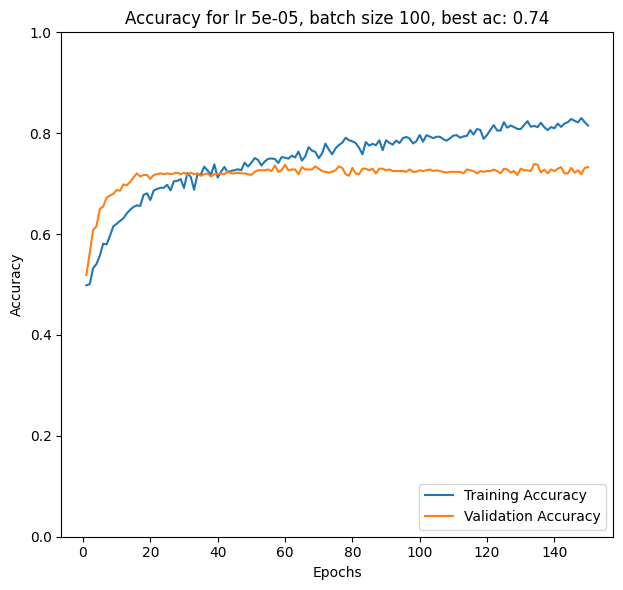

Classification Report:
              precision    recall  f1-score   support

     class 0       0.74      0.77      0.75       331
     class 1       0.74      0.71      0.72       309

    accuracy                           0.74       640
   macro avg       0.74      0.74      0.74       640
weighted avg       0.74      0.74      0.74       640



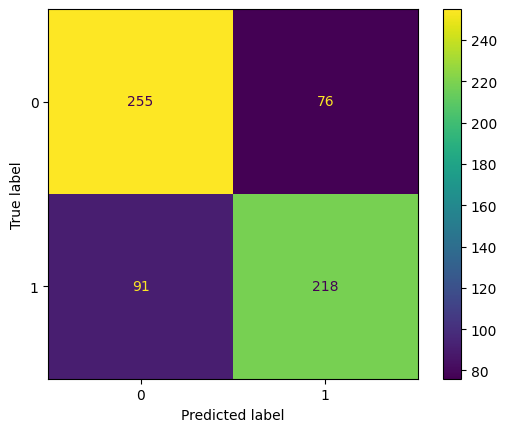

In [10]:
epochs =150
n_classes = 2
bn = 100
lr = 5e-5
stem_v = False
pool_v = 'mean'
norm_v = False
dr = 0.5



for stem_v in [True, False]:

    train_data = CustomPropagandaDataset_vanilla(train_df, glove_embeddings, pool=pool_v, stems=stem_v)
    val_data = CustomPropagandaDataset_vanilla(val_df, glove_embeddings, pool=pool_v, stems=stem_v)
    
    train_dataloader=torch.utils.data.DataLoader(train_data,batch_size=bn,shuffle=True)
    val_dataloader=torch.utils.data.DataLoader(val_data,batch_size=bn)

    model=Custom_MLP(num_classes=n_classes, dropout=dr).to(device)
    criterion=nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)

    train_acc_list = []
    train_loss_list = []
    val_acc_list = []
    val_loss_list = []

    best_val_acc = 0
    best_epoch = 0
    best_model_state = None

    model_id = str(uuid.uuid4())


    for epoch_num in range(epochs):

        total_acc_train=0
        total_loss_train=0
        model.train()

        for train_input,train_label in train_dataloader:

            train_input = train_input.to(device).float()
            train_label = train_label.to(device)
            output_1=model(train_input)

            batch_loss_1=criterion(output_1,train_label)

            total_loss_train += batch_loss_1.item()

            acc=(output_1.argmax(dim=1)==train_label).sum().item()
            total_acc_train+=acc

            model.zero_grad()
            batch_loss_1.backward()
            optimizer.step()

        total_acc_val=0
        total_loss_val=0

        y_true = []
        y_pred = []
        model.eval()
        with torch.no_grad():
            for val_input,val_label in val_dataloader:

                val_input = val_input.to(device).float()
                val_label = val_label.to(device)

                output_2=model(val_input)

                batch_loss_2=criterion(output_2,val_label)

                total_loss_val+=batch_loss_2.item()

                acc=(output_2.argmax(dim=1)==val_label).sum().item()
                total_acc_val+=acc

                # for scoring
                predicted = output_2.argmax(dim=1)
                y_true.extend(val_label.cpu().numpy())
                y_pred.extend(predicted.cpu().numpy())
        
        train_acc = total_acc_train / len(train_data)
        train_loss = total_loss_train / len(train_data)
        val_acc = total_acc_val / len(val_data)
        val_loss = total_loss_val / len(val_data)

        train_acc_list.append(train_acc)
        train_loss_list.append(train_loss)
        val_acc_list.append(val_acc)
        val_loss_list.append(val_loss)

        print(f'Epochs: {epoch_num+1} | Train Loss: {total_loss_train / len(train_data):.3f} | Train Accuracy: {total_acc_train/len(train_data):.3f}')
        print(f'Val loss: {total_loss_val/len(val_data):.3f} | Val Accuracy: {total_acc_val / len(val_data):.3f}')
        if val_acc > best_val_acc:
            best_epoch = epoch_num
            y_true_best = y_true.copy()
            y_pred_best = y_pred.copy()
            best_val_acc = val_acc
            best_model_state = model.state_dict()

        # if epoch_num == epochs-1:
        #     print(f'______{model_id}______')
        #     print(f'LR: {lr} FINAL ACC = {total_acc_val / len(val_data):.3f}')
        #     print(f'LR: {lr} BEST ACC = {best_val_acc:.3f}')
        #     print('____________')
            
    # Plot the accuracy and loss curves over epochs
    epochs_range = range(1, epochs+1)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_acc_list, label='Training Accuracy')
    plt.plot(epochs_range, val_acc_list, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.ylim(0, 1)  # Set y-axis limits from 0 to 1 for accuracy
    plt.title(f'Accuracy for lr {lr}, batch size {bn}, best ac: {best_val_acc:.2f}')

    # plt.subplot(1, 2, 2)
    # plt.plot(epochs_range, train_loss_list, label='Training Loss')
    # plt.plot(epochs_range, val_loss_list, label='Validation Loss')
    # plt.xlabel('Epochs')
    # plt.ylabel('Loss')
    # plt.legend(loc='upper right')
    # plt.title('Loss Curves')

    plt.tight_layout()
    plt.show()
    # analysis of best performing model
    
    # analysis of best performing model
    cm = confusion_matrix(y_true_best, y_pred_best)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot()

    # Compute precision, recall, F1-score, and other metrics for the best model
    report = classification_report(y_true_best, y_pred_best, target_names=['class 0', 'class 1'])
    print('Classification Report:')
    print(report)

    results_dict = {
        'model_id': model_id,
        'train_accuracy': train_acc_list,
        'train_loss': train_loss_list,
        'val_accuracy': val_acc_list,
        'val_loss': val_loss_list,
        'hyperparameters': {
            'learning_rate': lr,
            'num_epochs': epochs,
            'batch_size': bn,
            'stem_v':stem_v,
            'pool_v':pool_v,
            'norm_v':norm_v,
            'dropout_rate': dr,
        },
        'results': {
            "classes": n_classes,
            "last_acc": val_acc_list[-1],
            'best_acc': best_val_acc,
            'best_acc_epoch': best_epoch,
            'confusion_matrix': cm.tolist(),
            'classification_report': report
        }
    }


    # Save the results dictionary as a JSON file with the model ID
    results_filename = f'./results/glove_binary/glove_binary_results_{model_id}.json'
    with open(results_filename, 'w') as f:
        json.dump(results_dict, f, indent=4)